# CIFAR-100 Classification with an LDA Head
This notebook trains a lightweight convolutional encoder with a linear discriminant analysis (LDA) head on CIFAR-100, then visualises the learned embedding space.


### Setup


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from src.lda import LDAHead, LDALoss, TrainableLDAHead, FullCovLDAHead, LowRankSimplexLDAHead

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)


device = cuda


### Data


In [3]:
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)
pin_memory = torch.cuda.is_available()

train_tfm = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR100(root='./data', train=True, transform=train_tfm, download=True)
test_ds  = datasets.CIFAR100(root='./data', train=False, transform=test_tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4, pin_memory=pin_memory)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=4, pin_memory=pin_memory)
len(train_ds), len(test_ds)


(50000, 10000)

### Model: encoder + LDA head (on-the-fly stats)


In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(256, dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.proj(x)

class DeepLDA(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = LDAHead(C, D)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)


### Train & Eval


In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot

model = DeepLDA(C=100, D=99).to(device)
opt = torch.optim.Adam(model.parameters())
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.NLLLoss()
#loss_fn = LDALoss()
loss_fn = nn.PoissonNLLLoss()

train_acc = []
test_acc = []

for epoch in range(1, 101):
    model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        y_oh = 100 * F.one_hot(y, num_classes=100).to(logits.dtype)  # shape [batch,100]
        loss = loss_fn(logits, y_oh)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        with torch.no_grad():
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)
    tr_acc = acc_sum / n_sum
    te_acc = evaluate(model, test_ld)
    train_acc.append(tr_acc)
    test_acc.append(te_acc)
    print(f"[{epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}")


[01] train loss=9.4653 acc=0.0982 | test acc=0.1429
[02] train loss=1.8579 acc=0.2165 | test acc=0.2192
[03] train loss=-0.8344 acc=0.3361 | test acc=0.3311
[04] train loss=-1.2283 acc=0.4145 | test acc=0.4092
[05] train loss=-1.4552 acc=0.4722 | test acc=0.4049
[06] train loss=-1.6092 acc=0.5111 | test acc=0.4580
[07] train loss=-1.7445 acc=0.5461 | test acc=0.4827
[08] train loss=-1.8404 acc=0.5700 | test acc=0.5055
[09] train loss=-1.9243 acc=0.5935 | test acc=0.4933
[10] train loss=-1.9915 acc=0.6117 | test acc=0.5559
[11] train loss=-2.0587 acc=0.6294 | test acc=0.5501
[12] train loss=-2.1123 acc=0.6474 | test acc=0.5645
[13] train loss=-2.1671 acc=0.6596 | test acc=0.5557
[14] train loss=-2.2047 acc=0.6718 | test acc=0.5505
[15] train loss=-2.2484 acc=0.6823 | test acc=0.5938
[16] train loss=-2.2885 acc=0.6963 | test acc=0.5882
[17] train loss=-2.3268 acc=0.7081 | test acc=0.5935
[18] train loss=-2.3592 acc=0.7169 | test acc=0.5850
[19] train loss=-2.3917 acc=0.7240 | test acc=0.

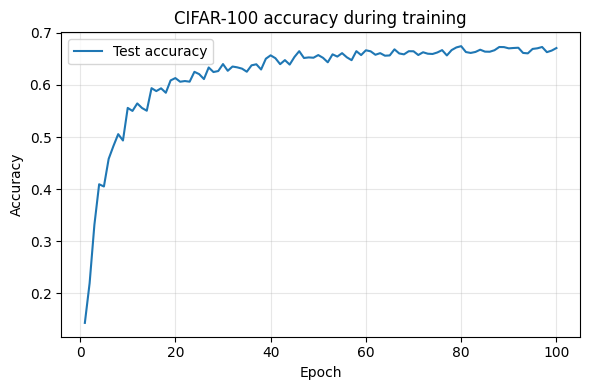

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(6, 4))
#plt.plot(epochs, train_acc, label='Train accuracy')
plt.plot(epochs, test_acc, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CIFAR-100 accuracy during training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [7]:
# Save trained model
save_path = 'cifar100_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
}, save_path)
print(f'Saved model checkpoint to {save_path}')

Saved model checkpoint to cifar100_model.pth


In [8]:
# # Load saved model
# checkpoint = torch.load('cifar100_model.pth', map_location=device)
# model = DeepLDA(C=100, D=99).to(device)
# opt = torch.optim.Adam(model.parameters())
# model.load_state_dict(checkpoint['model_state_dict'])
# opt.load_state_dict(checkpoint['optimizer_state_dict'])
# model.eval()
# print('Loaded checkpoint from cifar100_model.pth')


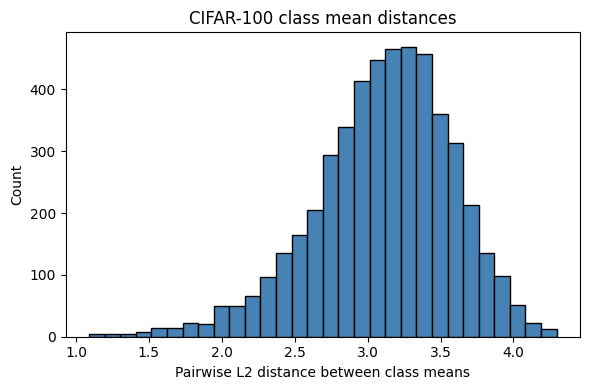

In [9]:
# Compute class means on training data and plot pairwise distances
@torch.no_grad()
def compute_class_means(model, loader, num_classes=100):
    model.eval()
    embedding_dim = model.head.D
    sums = torch.zeros(num_classes, embedding_dim, device=device)
    counts = torch.zeros(num_classes, device=device)
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        z = model.encoder(x)
        sums.index_add_(0, y, z)
        counts.index_add_(0, y, torch.ones_like(y, dtype=torch.float))
    return (sums / counts.unsqueeze(1)).cpu()

class_means = compute_class_means(model, train_ld)
pairwise = torch.pdist(class_means, p=2).numpy()

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.hist(pairwise, bins=30, color='steelblue', edgecolor='black')
plt.xlabel('Pairwise L2 distance between class means')
plt.ylabel('Count')
plt.title('CIFAR-100 class mean distances')
plt.tight_layout()
plt.show()


Closest classes: 35 (girl) and 98 (woman), distance=1.0896


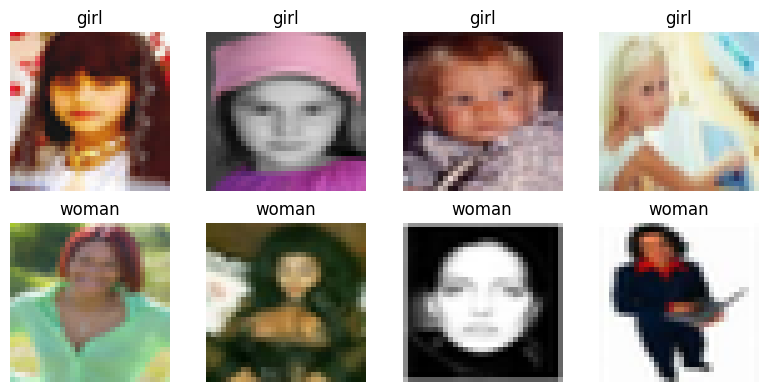

In [10]:
# Show a few examples from the two closest classes
import numpy as np

# Find closest pair using class means from the previous cell
with torch.no_grad():
    dist_mat = torch.cdist(class_means, class_means)
    dist_mat.fill_diagonal_(float('inf'))
    row_min, row_argmin = dist_mat.min(dim=1)
    cls_a = row_min.argmin().item()
    cls_b = row_argmin[cls_a].item()

cls_names = train_ds.classes
print(f"Closest classes: {cls_a} ({cls_names[cls_a]}) and {cls_b} ({cls_names[cls_b]}), distance={dist_mat[cls_a, cls_b]:.4f}")

# Collect a few raw images (no augmentation) for each class from the training set
n_per_class = 4
indices_a = [i for i, t in enumerate(train_ds.targets) if t == cls_a][:n_per_class]
indices_b = [i for i, t in enumerate(train_ds.targets) if t == cls_b][:n_per_class]

fig, axes = plt.subplots(2, n_per_class, figsize=(2 * n_per_class, 4))
for j, idx in enumerate(indices_a):
    axes[0, j].imshow(train_ds.data[idx])
    axes[0, j].axis('off')
    axes[0, j].set_title(f"{cls_names[cls_a]}")
for j, idx in enumerate(indices_b):
    axes[1, j].imshow(train_ds.data[idx])
    axes[1, j].axis('off')
    axes[1, j].set_title(f"{cls_names[cls_b]}")
plt.tight_layout()
plt.show()


2nd closest classes: 55 (otter) and 72 (seal), distance=1.0903


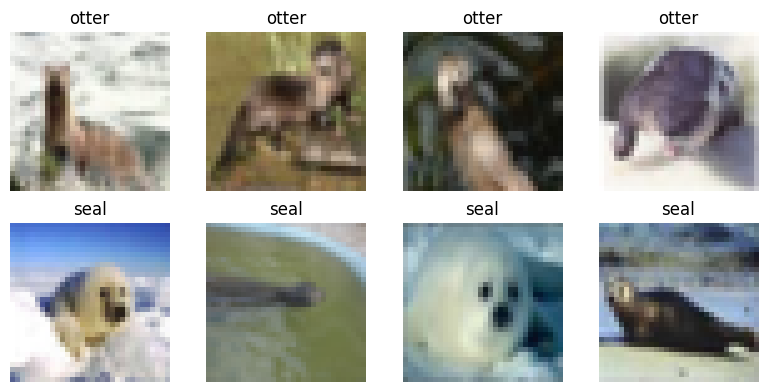

In [11]:
# Show examples from the 2nd closest pair of classes
# Assumes class_means computed above
with torch.no_grad():
    dist_mat = torch.cdist(class_means, class_means)
    dist_mat.fill_diagonal_(float('inf'))
    i_idx, j_idx = torch.triu_indices(dist_mat.size(0), dist_mat.size(1), offset=1)
    pair_dists = dist_mat[i_idx, j_idx]
    if pair_dists.numel() < 2:
        raise RuntimeError('Need at least two class pairs to find the 2nd closest pair.')
    sorted_vals, sorted_idx = torch.sort(pair_dists)
    second_idx = sorted_idx[1].item()
    cls_a = i_idx[second_idx].item()
    cls_b = j_idx[second_idx].item()
    pair_dist = sorted_vals[1].item()

cls_names = train_ds.classes
print(f"2nd closest classes: {cls_a} ({cls_names[cls_a]}) and {cls_b} ({cls_names[cls_b]}), distance={pair_dist:.4f}")

n_per_class = 4
indices_a = [i for i, t in enumerate(train_ds.targets) if t == cls_a][:n_per_class]
indices_b = [i for i, t in enumerate(train_ds.targets) if t == cls_b][:n_per_class]

fig, axes = plt.subplots(2, n_per_class, figsize=(2 * n_per_class, 4))
for j, idx in enumerate(indices_a):
    axes[0, j].imshow(train_ds.data[idx])
    axes[0, j].axis('off')
    axes[0, j].set_title(f"{cls_names[cls_a]}")
for j, idx in enumerate(indices_b):
    axes[1, j].imshow(train_ds.data[idx])
    axes[1, j].axis('off')
    axes[1, j].set_title(f"{cls_names[cls_b]}")
plt.tight_layout()
plt.show()
